In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# load training and testing set
# define shuffle data loader?
# got csv files from https://pjreddie.com/projects/mnist-in-csv/
HOME="/home/adsgray"
DIR=HOME + "/code/mnist"
TRAINING=DIR + "/mnist_train.csv"
TESTING=DIR + "/mnist_test.csv"



In [3]:
trainingfile = open(TRAINING, "r")
testingfile = open(TESTING, "r")
traininglines = trainingfile.readlines()
testinglines = testingfile.readlines()

def tensor_from_string(s):
    l = [int(i) for i in s.split(",")]
    #map(int, l)
    return tensor(l)

    
training_raw = torch.stack([tensor_from_string(s) for s in traininglines])
testing_raw = torch.stack([tensor_from_string(s) for s in testinglines])



In [4]:

training_labels = training_raw[:,0]
training_images = training_raw[:,1:].float()/255

testing_labels = testing_raw[:,0]
testing_images = testing_raw[:,1:].float()/255
#show_image(t[0].view(28,28))
#testing_labels[59]
#show_image(testing_images[59].view(28,28))

testing_images.shape[0]

10000

In [158]:
# functions to select a random sample
import random

training_max = training_images.shape[0]
training_indexes_available = set(range(0,training_max))

def reset_training_indexes():
    training_indexes_available = set(range(0,training_max))

def random_indexes_from_set(num):
    ret = random.sample(training_indexes_available, num)
    training_indexes_available.difference_update(ret)
    return ret

def random_indexes(num, max):
    return [random.randrange(0,max) for i in range(num)]

def training_sample(num):
    max = training_images.shape[0]
    #idxs = random_indexes(num, training_max)
    idxs = list(random_indexes_from_set(num))
    return [(training_images[idxs], training_labels[idxs])]

#print(training_indexes_available)



In [6]:
# define cost function

from torch import exp
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
def sigmoid(x): return 1/(1+torch.exp(-x))

fudge=1.

def mnist_loss(predictions, targets):
    return F.nll_loss(F.log_softmax(predictions, dim=1), targets)

    
def mnist_loss2(predictions, targets):
    lp = torch.log(predictions)
    sm = softmax(lp)
    #print("sm: ", sm)
    predictions = -sm
    #predictions = softmax(predictions)
    return predictions[range(targets.shape[0]), targets].mean()
   

In [86]:
# initialize parameters
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()


width=256
w1 = init_params((28*28,width))
b1 = init_params(width)
w2 = init_params((width,10))
b2 = init_params(10)

params = (w1,b1,w2,b2)


In [87]:
# define simple network
def simple_net(xb): 
    res = xb@w1 + b1
    # relu
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [60]:
incorrect=list()
badguesses=list()
correct=list()

In [164]:

print_acc = True
save_incor = True


def accuracy(preds, x, y):
    prednums = preds[range(y.shape[0]),y]
    maxes = torch.max(preds, dim=1)
    cor = prednums == maxes.values
    
    if save_incor:
        incor = [i for i,j in zip(x,cor) if not j]
        wrongguess = [g for g,j in zip(preds,cor) if not j]
        c = [y for y,j in zip(y,cor) if not j]
        incorrect.extend(incor)
        badguesses.extend(wrongguess)
        correct.extend(c)
    
    acc = cor.float().mean()
    return acc
    


def calc_grad(xb, yb, model):
    preds = model(xb)
    if print_acc:
        acc = accuracy(preds, xb, yb)
        print(acc)
    #print("preds: ", preds)
    #print("yb: ", yb)
    loss = mnist_loss(preds, yb)
    print("loss: ", loss)
    loss.backward()

# weight decay
wd = .005
def train_epoch_internal(model, lr, params, dl):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            #print("grad: ", p.grad)
            #parameters.grad += wd * 2 * parameters
            p.grad += wd * p.data
            p.data -= p.grad*lr
            p.grad.zero_()
            
    
def train_epoch(size, model, lr, params):
    dl = training_sample(size)
    train_epoch_internal(model, lr, params, dl)

def train_on_incorrect(model, lr, params):
    dl = [(torch.stack(incorrect), torch.stack(correct))]
    train_epoch_internal(model, lr, params, dl)

# run the model against the test set and print accuracy
def test_model(xb, yb, model, params):
    preds = model(xb)
    acc = accuracy(preds,xb,yb)
    print("test accuracy: ", acc)
    # reset params gradients so this test doesn't affect training?
    for p in params:
        p.grad.zero_()
    


In [1029]:
torch.stack(correct)

tensor([8, 2, 4, 3, 3, 1, 7, 9, 5, 5, 6, 7, 3, 5, 8, 5, 5, 7, 8, 3, 6, 9, 7, 9, 0, 4, 8, 3, 8, 3, 2, 3, 7, 2, 2, 3, 9, 2, 8, 3, 2, 4, 3, 8, 8, 2, 9, 3, 5, 3, 8, 7, 4, 6, 5, 0, 8, 6, 8, 2, 3, 8, 4, 7,
        7, 8, 1, 5, 2, 5, 8, 7, 0, 8, 8, 7, 2, 5, 4, 8, 4, 9, 7, 8, 7, 8, 5, 5, 2, 3, 8, 2, 0, 3, 5, 3, 8, 4, 9, 3, 1, 3, 8, 5, 1, 8, 8, 2, 2, 5, 2, 9, 2, 0, 5, 2, 5, 8, 3, 8, 5, 8, 3, 3, 3, 6, 7, 0,
        3, 4, 7, 4, 2, 6, 6, 5, 4, 6, 2, 2, 3, 9, 2, 4, 6, 7, 5, 9, 7, 7, 5, 5, 5, 3, 2, 9, 8, 0, 2, 7, 9, 5, 3, 3, 5, 7, 3, 3, 7, 3, 2, 7, 3, 0, 6, 7, 9, 9, 7, 9, 1, 6, 9, 6, 9, 9, 5, 7, 3, 0, 1, 8,
        9, 8, 9, 6, 9, 0, 5, 4, 8, 8, 6, 8, 6, 6, 3, 7, 4, 2, 9, 7, 3, 6, 1, 5, 5, 3, 9, 8, 6, 3, 4, 7, 5, 9, 5, 7, 3, 3, 9, 5, 4, 8, 8, 4, 9, 2, 7, 1, 3, 7, 6, 3, 3, 3, 0, 7, 5, 3, 7, 6, 6])

tensor([ 12.8066, -33.6041, -28.2903, -19.1194,  13.8405, -36.2888, -15.7823,  58.9041,   0.1675,  34.9782], grad_fn=<UnbindBackward>)
guess:  tensor(7)
actual:  tensor(9)


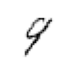

In [172]:
n=6
show_image(incorrect[n].view(28,28))
print(badguesses[n])
print("guess: ", torch.argmax(badguesses[n]))
print("actual: ", correct[n])


preds:  tensor([[  74.9436,   92.1547, -326.0612,   69.1091, -101.1812,   12.6790,   73.7510,   29.3107,  -37.1635,  194.3238]], grad_fn=<AddBackward0>)
tensor([9])


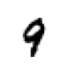

In [13]:
t = training_sample(1)

for (d,y) in t:
    p = simple_net(d)
    #print(d.shape)
    show_image(d.view(28,28))
    print("preds: ", p)
    print(y)

In [159]:
# training loop
#https://stackoverflow.com/questions/60032073/select-specific-rows-of-2d-pytorch-tensor


#def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()
#def linear1(xb): return xb@weights + bias


def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

lr = 0.005
num=20
size=400
chunks = int(training_max / size) - 1
print("chunks: ", chunks)
# train

def train_model(size, model, params, lr, num):
    for i in range(chunks):
        train_epoch(size, model, lr, params)
       


#print(params)
reset_training_indexes()
train_model(size, simple_net, params, lr, num)
#test_model(testing_images, testing_labels, simple_net, params)
#save_model()

#train_on_incorrect(simple_net, lr, params)





chunks:  149
tensor(0.8850)
loss:  tensor(3.2863, grad_fn=<NllLossBackward>)
tensor(0.8850)
loss:  tensor(3.1395, grad_fn=<NllLossBackward>)
tensor(0.9200)
loss:  tensor(2.1946, grad_fn=<NllLossBackward>)
tensor(0.9000)
loss:  tensor(1.9763, grad_fn=<NllLossBackward>)
tensor(0.9025)
loss:  tensor(3.0569, grad_fn=<NllLossBackward>)
tensor(0.9150)
loss:  tensor(2.1802, grad_fn=<NllLossBackward>)
tensor(0.8800)
loss:  tensor(2.7350, grad_fn=<NllLossBackward>)
tensor(0.9175)
loss:  tensor(1.8186, grad_fn=<NllLossBackward>)
tensor(0.8725)
loss:  tensor(3.2158, grad_fn=<NllLossBackward>)
tensor(0.8950)
loss:  tensor(2.6953, grad_fn=<NllLossBackward>)
tensor(0.8800)
loss:  tensor(3.1916, grad_fn=<NllLossBackward>)
tensor(0.8750)
loss:  tensor(3.4329, grad_fn=<NllLossBackward>)
tensor(0.9175)
loss:  tensor(1.8514, grad_fn=<NllLossBackward>)
tensor(0.9100)
loss:  tensor(2.5495, grad_fn=<NllLossBackward>)
tensor(0.9075)
loss:  tensor(2.9119, grad_fn=<NllLossBackward>)
tensor(0.8925)
loss:  tenso

tensor(0.8775)
loss:  tensor(3.5419, grad_fn=<NllLossBackward>)
tensor(0.8825)
loss:  tensor(2.6431, grad_fn=<NllLossBackward>)
tensor(0.9025)
loss:  tensor(2.2238, grad_fn=<NllLossBackward>)
tensor(0.8700)
loss:  tensor(3.5125, grad_fn=<NllLossBackward>)
tensor(0.8775)
loss:  tensor(3.3316, grad_fn=<NllLossBackward>)
tensor(0.9100)
loss:  tensor(1.9932, grad_fn=<NllLossBackward>)
tensor(0.9050)
loss:  tensor(3.0647, grad_fn=<NllLossBackward>)
tensor(0.9275)
loss:  tensor(1.2045, grad_fn=<NllLossBackward>)
tensor(0.9025)
loss:  tensor(2.7749, grad_fn=<NllLossBackward>)
tensor(0.9125)
loss:  tensor(2.6512, grad_fn=<NllLossBackward>)
tensor(0.8875)
loss:  tensor(3.0729, grad_fn=<NllLossBackward>)
tensor(0.9175)
loss:  tensor(1.8845, grad_fn=<NllLossBackward>)
tensor(0.8675)
loss:  tensor(4.3743, grad_fn=<NllLossBackward>)
tensor(0.9075)
loss:  tensor(3.3288, grad_fn=<NllLossBackward>)


In [165]:
test_model(testing_images, testing_labels, simple_net, params)


test accuracy:  tensor(0.8935)


In [11]:
# write out model to disk
import pickle

def save_model():
    model = {'w1':w1, 'b1': b1, 'w2':w2, 'b2': b2}
    with open('mymodel.pkl', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_model():
    with open('mymodel.pkl', 'rb') as handle:
        model = pickle.load(handle)
    w1 = model['w1']
    b1 = model['b1']
    w2 = model['w2']
    b2 = model['b2']


    
#save_model()
read_model()


